In [ ]:
from pgmpy.readwrite import BIFReader
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
import matplotlib.pyplot as plt

reader = BIFReader("asia.bif")
model = reader.get_model()

print("Nodes:", model.nodes())
print("Edges:", model.edges())

Nodes: ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']
Edges: [('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]


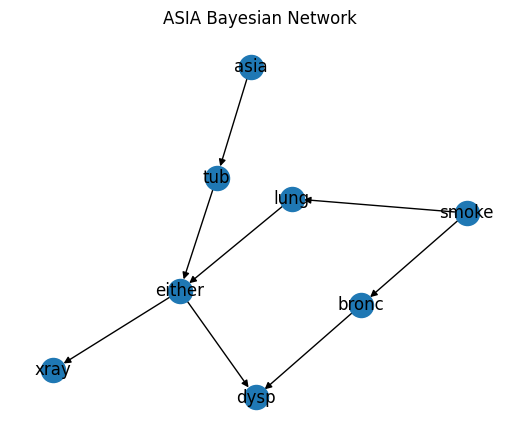

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

plt.figure(figsize=(5, 4))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, arrows=True)
plt.title("ASIA Bayesian Network")
plt.show()


In [9]:
for cpd in model.get_cpds():
    print(cpd)


+-----------+------+
| asia(yes) | 0.01 |
+-----------+------+
| asia(no)  | 0.99 |
+-----------+------+
+------------+------------+-----------+
| smoke      | smoke(yes) | smoke(no) |
+------------+------------+-----------+
| bronc(yes) | 0.6        | 0.3       |
+------------+------------+-----------+
| bronc(no)  | 0.4        | 0.7       |
+------------+------------+-----------+
+-----------+-------------+------------+-------------+------------+
| bronc     | bronc(yes)  | bronc(yes) | bronc(no)   | bronc(no)  |
+-----------+-------------+------------+-------------+------------+
| either    | either(yes) | either(no) | either(yes) | either(no) |
+-----------+-------------+------------+-------------+------------+
| dysp(yes) | 0.9         | 0.8        | 0.7         | 0.1        |
+-----------+-------------+------------+-------------+------------+
| dysp(no)  | 0.1         | 0.2        | 0.3         | 0.9        |
+-----------+-------------+------------+-------------+------------+
+--

## Sample Observational Data

In [18]:
sampler = BayesianModelSampling(model)

N_OBS = 5000
data_obs = sampler.forward_sample(size=N_OBS)
data_obs.head()


  0%|          | 0/8 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/ADS/lib/python3.11/site-packages/pgmpy/sampling/base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,asia,tub,smoke,lung,bronc,either,xray,dysp
0,no,no,yes,yes,no,yes,yes,yes
1,no,no,yes,no,yes,no,no,no
2,no,no,no,no,no,no,no,no
3,no,no,yes,no,no,no,no,no
4,no,no,yes,no,no,no,yes,no


In [19]:
from pgmpy.estimators import HillClimbSearch, BicScore

def learn_hc_bic(data):
    """Learn a BN structure from data using Hill-Climb + BIC."""
    hc = HillClimbSearch(data)
    best_model = hc.estimate(scoring_method=BicScore(data))
    return best_model

learned_obs = learn_hc_bic(data_obs)

print("True edges:   ", set(model.edges()))
print("Learned edges:", set(learned_obs.edges()))


  0%|          | 0/1000000 [00:00<?, ?it/s]

True edges:    {('asia', 'tub'), ('smoke', 'lung'), ('smoke', 'bronc'), ('tub', 'either'), ('either', 'dysp'), ('bronc', 'dysp'), ('lung', 'either'), ('either', 'xray')}
Learned edges: {('bronc', 'smoke'), ('either', 'bronc'), ('tub', 'asia'), ('either', 'dysp'), ('lung', 'tub'), ('lung', 'smoke'), ('dysp', 'bronc'), ('xray', 'either'), ('either', 'tub'), ('either', 'lung')}


In [20]:
def edge_sets_edges_only(G):
    """Return directed and undirected edge sets from a pgmpy model."""
    directed = set(G.edges())
    undirected = {frozenset(e) for e in directed}
    return directed, undirected

def structural_hamming_distance(true_model, learned_model):
    """
    SHD between two DAGs:
    - 1 for each missing undirected edge
    - 1 for each extra undirected edge
    - 1 for each orientation mismatch of shared undirected edges
    """
    true_dir, true_und = edge_sets_edges_only(true_model)
    learn_dir, learn_und = edge_sets_edges_only(learned_model)

    missing_und = true_und - learn_und
    extra_und   = learn_und - true_und
    common_und  = true_und & learn_und

    orientation_errors = 0
    for und in common_und:
        u, v = tuple(und)
        # Edge may appear as (u,v) or (v,u)
        true_has_uv = (u, v) in true_dir
        true_has_vu = (v, u) in true_dir
        learn_has_uv = (u, v) in learn_dir
        learn_has_vu = (v, u) in learn_dir

        # orientation error if directions differ
        if (true_has_uv, true_has_vu) != (learn_has_uv, learn_has_vu):
            orientation_errors += 1

    shd = len(missing_und) + len(extra_und) + orientation_errors
    return shd

shd_obs = structural_hamming_distance(model, learned_obs)
print("SHD (observational only):", shd_obs)


SHD (observational only): 9


### Do intervention: do(X=stat_name)

- remove incoming edge to X

- Replace its conditional probability table with a degenerate one that always outputs that state

In [21]:
from pgmpy.factors.discrete import TabularCPD
from copy import deepcopy

def do_intervention(model, var, state_name):
    """
    Return a new model representing do(var = state_name).
    Assumes var is discrete and already has a CPD in the original model.
    """
    new_model = deepcopy(model)

    # Remove all incoming edges to `var`
    for parent in list(new_model.get_parents(var)):
        new_model.remove_edge(parent, var)

    # Get original CPD to copy state names and cardinality
    old_cpd = new_model.get_cpds(var)
    state_names = old_cpd.state_names[var]
    card = len(state_names)

    # Find index of the desired state
    try:
        idx = state_names.index(state_name)
    except ValueError:
        raise ValueError(f"State {state_name} not found in {var}'s states: {state_names}")

    # Build a delta CPD: P(var = state_name) = 1
    # Shape: (cardinality, 1) because there are no parents anymore
    values = [[1.0] if i == idx else [0.0] for i in range(card)]

    new_cpd = TabularCPD(
        variable=var,
        variable_card=card,
        values=values,
        state_names={var: state_names},
    )

    new_model.remove_cpds(old_cpd)
    new_model.add_cpds(new_cpd)
    new_model.check_model()
    return new_model



In [22]:
model_do_smoke_yes = do_intervention(model, "smoke", "yes")
sampler_do = BayesianModelSampling(model_do_smoke_yes)
data_do_smoke_yes = sampler_do.forward_sample(size=2000)
data_do_smoke_yes.head()

  0%|          | 0/8 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/ADS/lib/python3.11/site-packages/pgmpy/sampling/base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,asia,tub,smoke,lung,bronc,either,xray,dysp
0,no,no,yes,no,yes,no,no,yes
1,no,no,yes,no,yes,no,no,yes
2,no,no,yes,no,yes,no,no,yes
3,no,no,yes,no,yes,no,no,yes
4,no,no,yes,no,yes,no,no,yes


In [23]:
import pandas as pd

print("P(smoke | observational):")
print(data_obs["smoke"].value_counts(normalize=True))

print("\nP(smoke | do(smoke=yes)):")
print(data_do_smoke_yes["smoke"].value_counts(normalize=True))


P(smoke | observational):
smoke
yes    0.5108
no     0.4892
Name: proportion, dtype: float64

P(smoke | do(smoke=yes)):
smoke
yes    1.0
Name: proportion, dtype: float64


In [24]:
def prob_yes(df, col):
    return (df[col] == "yes").mean()

print("P(dysp = yes) observational:", prob_yes(data_obs, "dysp"))

print("P(dysp = yes | smoke = yes) observational:",
      prob_yes(data_obs[data_obs["smoke"] == "yes"], "dysp"))

print("P(dysp = yes | do(smoke = yes)):",
      prob_yes(data_do_smoke_yes, "dysp"))


P(dysp = yes) observational: 0.4602
P(dysp = yes | smoke = yes) observational: 0.5853563038371182
P(dysp = yes | do(smoke = yes)): 0.5635


In [25]:
import pandas as pd

data_mixed = pd.concat([data_obs, data_do_smoke_yes], ignore_index=True)

learned_mixed = learn_hc_bic(data_mixed)

print("Learned edges (obs + do(smoke=yes)):", set(learned_mixed.edges()))

shd_mixed = structural_hamming_distance(model, learned_mixed)
print("SHD (with interventional data):", shd_mixed)

print("\nSHD comparison:")
print("  Observational only:", shd_obs)
print("  Obs + do(smoke=yes):", shd_mixed)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned edges (obs + do(smoke=yes)): {('bronc', 'smoke'), ('either', 'bronc'), ('tub', 'asia'), ('either', 'dysp'), ('lung', 'smoke'), ('dysp', 'bronc'), ('either', 'tub'), ('either', 'lung'), ('either', 'xray'), ('tub', 'lung')}
SHD (with interventional data): 8

SHD comparison:
  Observational only: 9
  Obs + do(smoke=yes): 8


In [26]:
model_do_either_yes = do_intervention(model, "either", "yes")
sampler_do = BayesianModelSampling(model_do_either_yes)
data_do_either_yes = sampler_do.forward_sample(size=2000)
data_do_either_yes.head()

  0%|          | 0/8 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/ADS/lib/python3.11/site-packages/pgmpy/sampling/base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,asia,tub,smoke,lung,bronc,either,xray,dysp
0,no,no,yes,no,no,yes,yes,yes
1,no,no,no,no,no,yes,yes,yes
2,no,no,no,no,yes,yes,no,yes
3,no,no,yes,no,yes,yes,yes,yes
4,no,no,yes,no,no,yes,yes,yes


In [29]:
print("P(either | observational):")
print(data_obs["either"].value_counts(normalize=True))

print("\nP(either | do(either=yes)):")
print(data_do_either_yes["either"].value_counts(normalize=True))

print("P(dysp = yes) observational:", prob_yes(data_obs, "dysp"))

print("P(dysp = yes | either = yes) observational:",
      prob_yes(data_obs[data_obs["either"] == "yes"], "dysp"))

print("P(dysp = yes | do(either = yes)):",
      prob_yes(data_do_either_yes, "dysp"))


P(either | observational):
either
no     0.9294
yes    0.0706
Name: proportion, dtype: float64

P(either | do(either=yes)):
either
yes    1.0
Name: proportion, dtype: float64
P(dysp = yes) observational: 0.4602
P(dysp = yes | either = yes) observational: 0.8243626062322946
P(dysp = yes | do(either = yes)): 0.793


In [30]:
data_mixed_2 = pd.concat([data_obs, data_do_either_yes], ignore_index=True)

learned_mixed_2 = learn_hc_bic(data_mixed_2)

print("Learned edges (obs + do(either=yes)):", set(learned_mixed_2.edges()))

shd_mixed_2 = structural_hamming_distance(model, learned_mixed_2)
print("SHD (with interventional data):", shd_mixed_2)

print("\nSHD comparison:")
print("  Observational only:", shd_obs)
print("  Obs + do(either=yes):", shd_mixed_2)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned edges (obs + do(either=yes)): {('smoke', 'bronc'), ('tub', 'asia'), ('either', 'dysp'), ('lung', 'smoke'), ('xray', 'either'), ('either', 'tub'), ('bronc', 'dysp'), ('either', 'lung')}
SHD (with interventional data): 5

SHD comparison:
  Observational only: 9
  Obs + do(either=yes): 5
